In [68]:
import numpy as np
import pandas as pd
import re
import math
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn import svm
import matplotlib.pyplot as plt
import matplotlib
import os
%matplotlib inline


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues, font_size=10, fig_size=(12,10)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)
    plt.rcParams.update({'font.size': font_size})
    fig, ax = plt.subplots(figsize=fig_size, dpi= 80, facecolor='w', edgecolor='k')
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

### Load and Trim Datasets
##Loads data and trims tuples down to correct 2 hour time period

In [69]:

def load_dataset(path):
    out_data = pd.DataFrame()
    for sub_dir in os.listdir(path):
        temp_path = os.path.join(path, sub_dir)
        temp_path = os.path.join(temp_path, "log_tcp_complete")
#        print(temp_path)
        if os.path.isfile(temp_path): 
#            print('1')
#            temp_data = read_in_file(temp_path)
            temp_data = pd.read_csv(temp_path, delimiter= '\s', index_col=False)
            temp_data.shape
            out_data = out_data.append(temp_data) 
        #np.concatenate((out_data, temp_data))
#    return 
    df = out_data
    #load data
#def trim_dataset(df):

    #create timestamp    
    df['t_first']=df['first:29'].astype('float').astype("datetime64[ms]")
    df['t_last']=df['last:30'].astype('float').astype("datetime64[ms]")

    #find start/end time
    t_start = df.t_first.min()
    t_end = t_start+ pd.Timedelta(hours=2)
    t_max = df.t_last.max()

    #trim data after test complete (tstat ran too long in bash shell)    
    df = df[(df['t_first'] >= t_start) & (df['t_last'] < t_end)]
#    df = df.values

    df.drop(columns=['t_first', 't_last'])
    df.drop(df.index[0])

#    csv = get_data_row(df.to_csv( index = False, sep = " "))

    return df

### Load Label Indexes
This chunk loads a file that contains the labels we want to load from the datasets as well as their indicies.

In [70]:
infile = open("tstat_labels_indexes.txt" ,'r')
data_field_list = []
for line in infile.readlines():
    if ":" in line:
        data_field = str(re.search('%s(.*)%s' % ("\"", "\""), line).group(1))
        index = int(re.search('%s(.*)%s' % (":", ","), line).group(1))
        data_field_list.append((data_field, index))

index_to_key_dict = {}
key_to_index_dict = {}
data_field_labels = []
for data_field, index in data_field_list:
    key_to_index_dict[data_field] = index
    index_to_key_dict[index] = data_field
    data_field_labels.append(data_field)
    
len(data_field_list)

89

### Read in a dataset file

In [71]:
def read_in_file(input):
    entries = []
    labels = None
    for i, line in enumerate(input):
        row = get_data_row(line)
        row = clean_data_row(row)
        if row != []:
            entries.append(row)
    entries = np.array(entries)
    return entries

### Get data row
Called by the read in file function. Loads a single line from the dataset files. Super inefficient, but only loads labels which are in the data field list. 

In [72]:
def get_data_row(line):
    global index_to_key_dict
#    print(line)
    row = []
    labels = []
    c_pkt_cnt = 0
    s_pkt_cnt = 0
    c_bytes_cnt = 0
    s_bytes_cnt = 0
    for data_field, index in data_field_list:
        if data_field == "client_pkt_cnt":
            try:
                c_pkt_cnt = line[index]
                c_pkt_cnt = max(float(c_pkt_cnt), 1)
            except:
                c_pkt_cnt = 1
            #if c_pkt_cnt < 32:
            #    return []
        elif data_field == "serv_pkt_cnt":
            try:
                s_pkt_cnt = line[index]
                s_pkt_cnt = max(float(s_pkt_cnt), 1)
            except:
                s_pkt_cnt = 1
        elif data_field == "client_bytes_cnt":
            try:
                c_bytes_cnt = line[index]
                c_bytes_cnt = max(float(c_bytes_cnt), 1)
            except:
                c_bytes_cnt = 1
        elif data_field == "serv_bytes_cnt":
            try:
                s_bytes_cnt = line[index]
                s_bytes_cnt = max(float(s_bytes_cnt), 1)
            except:
                s_bytes_cnt = 1
                
    for data_field, index in data_field_list:
        try:
            val = line[index]
            val = float(val)
        except:
            val = 0
        if data_field in ["client_pkt_cnt", "client_rst_cnt", "client_ack_cnt", "client_pkt_data", "client_pkt_retx",
                         "client_syn_cnt", "client_fin_cnt", "client_pkt_retx"]:
            val /= c_pkt_cnt
        elif data_field in ["client_bytes_uniq", "client_bytes_cnt", "client_bytes_retx"]:
            val /= c_bytes_cnt
        elif data_field in ["serv_pkt_cnt", "serv_rst_cnt", "serv_ack_cnt", "serv_ack_pck_cnt", "serv_pkts_data", 
                            "serv_pkts_retx", "serv_syn_cnt", "serv_fin_cnt"]:
            val /= s_pkt_cnt
        elif data_field in ["serv_bytes_uniq", "serv_btyes_cnt", "serv_pkts_retx"]:
            val /= s_bytes_cnt
        row.append(val)    
    return row

### Clean data row
Not implemented

In [73]:
def clean_data_row(in_row):
    global index_to_key_dict, key_to_index_dict

    for data_field, index in data_field_list:
        if math.isnan(in_row[index]):
            try:
                in_row[index] == 0
                
            except:
                print('err')


    
    return in_row

### Get dataset
Loads all files from a directory

In [74]:
def get_dataset(path):
    print(path)
    temp_data = load_dataset(path)
    temp_data = temp_data.drop(['t_first', 't_last'], axis=1)
#csv = (temp_data.to_csv( index = False, sep = " "))
#entries = []
#lines = csv.splitlines()

    entries = []

    temp_data = temp_data.values
    for row in temp_data:
        myRow = get_data_row(row)
        myRow= [float(i) for i in myRow]

#        myRow = clean_data_row(myRow)
        entries.append(myRow)

    entries = np.array(entries)

    return entries

    # add pandas to list and row algo

#pd.DataFrame(temp_data)
#print("output::", csv)

In [75]:

temp_data = get_dataset("./normal")

./normal


/home/dave/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # This is added back by InteractiveShellApp.init_path()


### Load all datasets
Load all datasets
Create numerical lables for each class, and a different set of labels for each subclass.

In [76]:
normal = get_dataset("./normal")
corr_01 = get_dataset("./corrupt_0.1perc")
corr_05 = get_dataset("./corrupt_0.5perc")
corr_10 = get_dataset("./corrupt_1.0perc")
delay_1_1 = get_dataset("./delay_1_var_1")
delay_5_2 = get_dataset("./delay_5_var_2")
delay_10_5 = get_dataset("./delay_10_var_5")
delay_25_20 = get_dataset("./delay_25_var_20")
drop_01 = get_dataset("./drop_01_perc")
drop_001 = get_dataset("./drop_001_perc")
drop_0005 = get_dataset("./drop_0005_perc")
dup_1 = get_dataset("./dup-1-p")
dup_2 = get_dataset("./dup_2perc")

normal = np.nan_to_num(normal)
corr_01 = np.nan_to_num(corr_01)
corr_05 =  np.nan_to_num(corr_05)
corr_10 = np.nan_to_num(corr_10)
delay_1_1 = np.nan_to_num(delay_1_1)
delay_5_2 = np.nan_to_num(delay_5_2)
delay_10_5 = np.nan_to_num(delay_10_5)
delay_25_20 = np.nan_to_num(delay_25_20)
drop_01 = np.nan_to_num(drop_01)
drop_001 = np.nan_to_num(drop_001)
drop_0005 = np.nan_to_num(drop_0005)
dup_1 = np.nan_to_num(dup_1)
dup_2 = np.nan_to_num(dup_2)



./normal


/home/dave/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # This is added back by InteractiveShellApp.init_path()


./corrupt_0.1perc
./corrupt_0.5perc
./corrupt_1.0perc
./delay_1_var_1
./delay_5_var_2
./delay_10_var_5
./delay_25_var_20
./drop_01_perc
./drop_001_perc
./drop_0005_perc
./dup-1-p
./dup_2perc


In [77]:

all_data = np.concatenate((normal,
                           corr_01, corr_05, corr_10,
                           delay_1_1, delay_5_2,delay_10_5,delay_25_20,
                           drop_01, drop_001, 
                           dup_1, dup_2))



In [78]:

all_data = np.concatenate((normal,
                           corr_01, corr_05, corr_10,
                           delay_1_1, delay_5_2,delay_10_5,delay_25_20,
                           drop_01, drop_001, drop_0005,
                           dup_1, dup_2))



In [79]:
all_data = np.nan_to_num(all_data)
all_data = StandardScaler().fit_transform(all_data)

In [80]:
a_labels  = np.ones(len(normal))      *1
b_labels  = np.ones(len(corr_01  ))   *2
c_labels  = np.ones(len(corr_05))      *3
d_labels  = np.ones(len(corr_10  ))   *4
e_labels  = np.ones(len(delay_1_1))   *5
f_labels  = np.ones(len(delay_5_2))   *6
g_labels  = np.ones(len(delay_10_5))  *7
h_labels  = np.ones(len(delay_25_20)) *8
i_labels  = np.ones(len(drop_01) )     *9
j_labels  = np.ones(len(drop_001) )    *10
k_labels  = np.ones(len(drop_0005) )   *11
m_labels  = np.ones(len(dup_1))       *13
n_labels  = np.ones(len(dup_2))       *14

data_labels = np.concatenate((a_labels, b_labels, c_labels, d_labels, e_labels,
                              f_labels, g_labels, h_labels,
                              i_labels, j_labels, k_labels, 
                              m_labels, n_labels))

a_labels  = np.ones(len(normal  ))    *1
b_labels  = np.ones(len(corr_01  ))   *2
c_labels  = np.ones(len(corr_05  ))   *2
d_labels  = np.ones(len(corr_10  ))   *2
e_labels  = np.ones(len(delay_1_1))   *3
f_labels  = np.ones(len(delay_5_2))   *3
g_labels  = np.ones(len(delay_10_5))  *3
h_labels  = np.ones(len(delay_25_20)) *3
i_labels  = np.ones(len(drop_01))     *4
j_labels  = np.ones(len(drop_001))    *4
k_labels  = np.ones(len(drop_0005))   *4
m_labels  = np.ones(len(dup_1))       *5
n_labels  = np.ones(len(dup_2))       *5

anom_type_data_labels = np.concatenate((a_labels, b_labels, c_labels, d_labels, e_labels,
                                        f_labels, g_labels, h_labels,
                                        i_labels, j_labels, k_labels, 
                                        m_labels, n_labels))


In [81]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(all_data, 
                                                                    anom_type_data_labels, test_size=0.45, random_state=0)



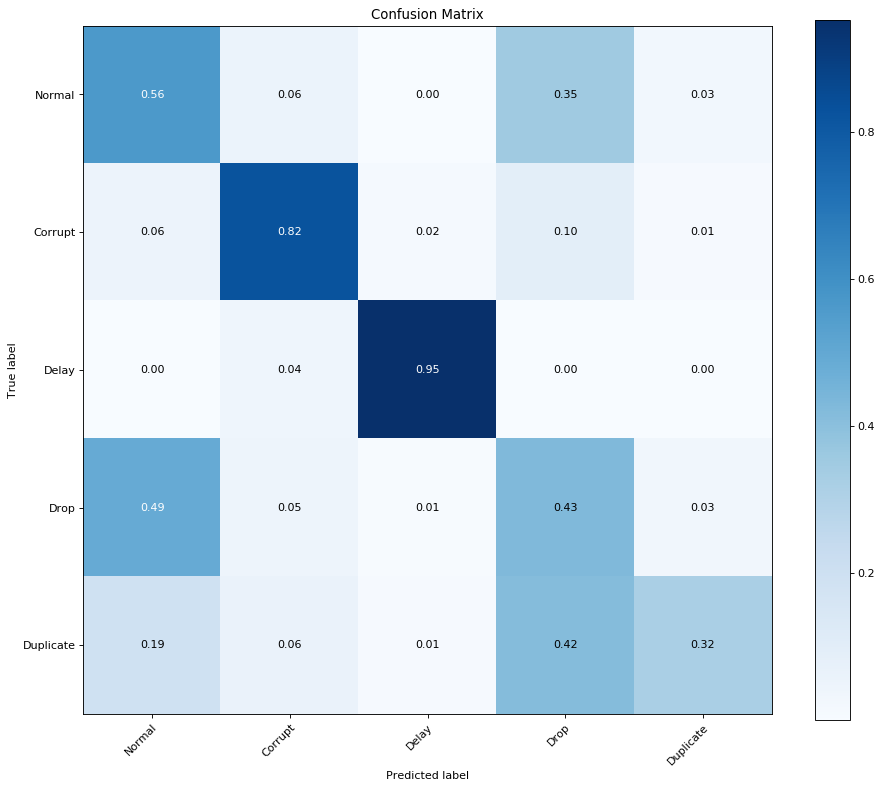

Total Error Count :  5460
Normal Class Error Rate :  19.806763285024154 %
Total Error Rate :  33.81642512077295 %
Total Errors 5460
False Positives  17.539947974730584 %
False Negatives  16.276477146042364 %


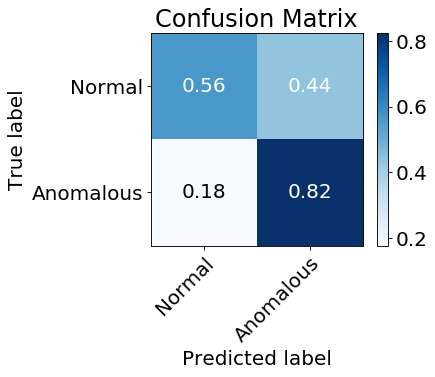

In [82]:
clf = svm.SVC(kernel='linear', gamma ='auto', max_iter=1000000000, class_weight='balanced')
clf.fit(train_data, train_labels)
predicted_labels = clf.predict(test_data)

from sklearn.metrics import confusion_matrix 

class_names = ["Normal", "Corrupt", "Delay", "Drop", "Duplicate"]

plot_confusion_matrix(test_labels, predicted_labels, normalize=True,classes=class_names, title='Confusion Matrix')
plt.show()

error_cnt = 0
total_error_cnt = 0
same_class_error = 0
for i in range(len(predicted_labels)):
    if predicted_labels[i] != test_labels[i]:
        total_error_cnt += 1
        # if its normal data
        if predicted_labels[i] == 1 or test_labels[i] == 1:
            error_cnt += 1


print ("Total Error Count : ", total_error_cnt)
print ("Normal Class Error Rate : ", float(error_cnt)/float(len(predicted_labels)) * 100, "%")
print ("Total Error Rate : ", float(total_error_cnt)/float(len(predicted_labels)) * 100, "%")


false_pos = 0
false_neg = 0
error_cnt = 0
for i in range(len(predicted_labels)):
    # if there's an error
    if predicted_labels[i] != test_labels[i]:
        error_cnt += 1
        # if we failed to detect anomaly
        if predicted_labels[i] == 1:
            false_neg += 1
        # detected anomaly, but it normal
        else:
            false_pos += 1
print ("Total Errors", error_cnt)
print ("False Positives ", false_pos/ float(len(predicted_labels)) * 100, "%")
print ("False Negatives ", false_neg/ float(len(predicted_labels)) * 100, "%")


shortened_predicted = []
shortened_test_label = []
for i in range(len(predicted_labels)):
    if predicted_labels[i] == 1:
        shortened_predicted.append(1)
    else:
        shortened_predicted.append(2)
    if test_labels[i] == 1:
        shortened_test_label.append(1)
    else:
        shortened_test_label.append(2)

short_class_names = ["Normal", "Anomalous"]        
        
    
    
plot_confusion_matrix(shortened_test_label, shortened_predicted, normalize=True,classes=short_class_names, 
                      title='Confusion Matrix', font_size=18, fig_size=(6,5))
plt.show()

In [83]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(all_data, 
                                                                    anom_type_data_labels, test_size=0.45, random_state=1)


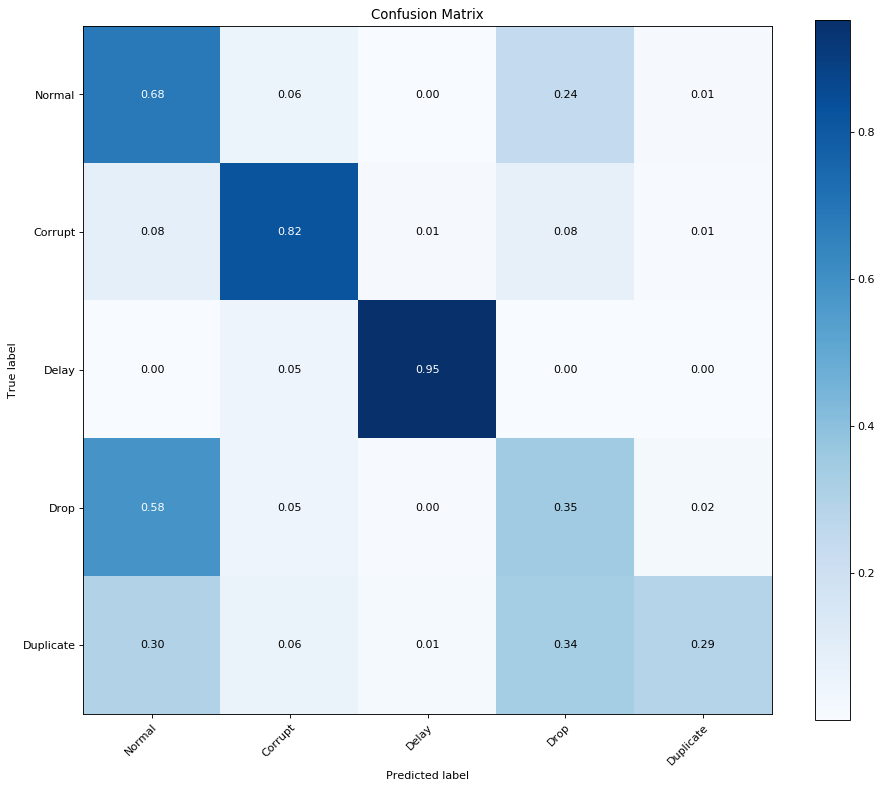

Total Error Count :  5631
Normal Class Error Rate :  23.00260126347083 %
Total Error Rate :  34.87551096246748 %
Total Errors 5631
False Positives  14.43701226309922 %
False Negatives  20.438498699368264 %


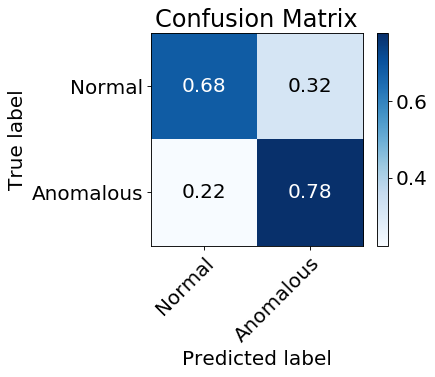

In [84]:
clf = svm.SVC(kernel='linear', gamma ='auto', max_iter=1000000000, class_weight='balanced')
clf.fit(train_data, train_labels)
predicted_labels = clf.predict(test_data)

from sklearn.metrics import confusion_matrix 

class_names = ["Normal", "Corrupt", "Delay", "Drop", "Duplicate"]

plot_confusion_matrix(test_labels, predicted_labels, normalize=True,classes=class_names, title='Confusion Matrix')
plt.show()

error_cnt = 0
total_error_cnt = 0
same_class_error = 0
for i in range(len(predicted_labels)):
    if predicted_labels[i] != test_labels[i]:
        total_error_cnt += 1
        # if its normal data
        if predicted_labels[i] == 1 or test_labels[i] == 1:
            error_cnt += 1


print ("Total Error Count : ", total_error_cnt)
print ("Normal Class Error Rate : ", float(error_cnt)/float(len(predicted_labels)) * 100, "%")
print ("Total Error Rate : ", float(total_error_cnt)/float(len(predicted_labels)) * 100, "%")


false_pos = 0
false_neg = 0
error_cnt = 0
for i in range(len(predicted_labels)):
    # if there's an error
    if predicted_labels[i] != test_labels[i]:
        error_cnt += 1
        # if we failed to detect anomaly
        if predicted_labels[i] == 1:
            false_neg += 1
        # detected anomaly, but it normal
        else:
            false_pos += 1
print ("Total Errors", error_cnt)
print ("False Positives ", false_pos/ float(len(predicted_labels)) * 100, "%")
print ("False Negatives ", false_neg/ float(len(predicted_labels)) * 100, "%")


shortened_predicted = []
shortened_test_label = []
for i in range(len(predicted_labels)):
    if predicted_labels[i] == 1:
        shortened_predicted.append(1)
    else:
        shortened_predicted.append(2)
    if test_labels[i] == 1:
        shortened_test_label.append(1)
    else:
        shortened_test_label.append(2)

short_class_names = ["Normal", "Anomalous"]        
        
    
    
plot_confusion_matrix(shortened_test_label, shortened_predicted, normalize=True,classes=short_class_names, 
                      title='Confusion Matrix', font_size=18, fig_size=(6,5))
plt.show()

In [85]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(all_data, 
                                                                    anom_type_data_labels, test_size=0.45, random_state=2)

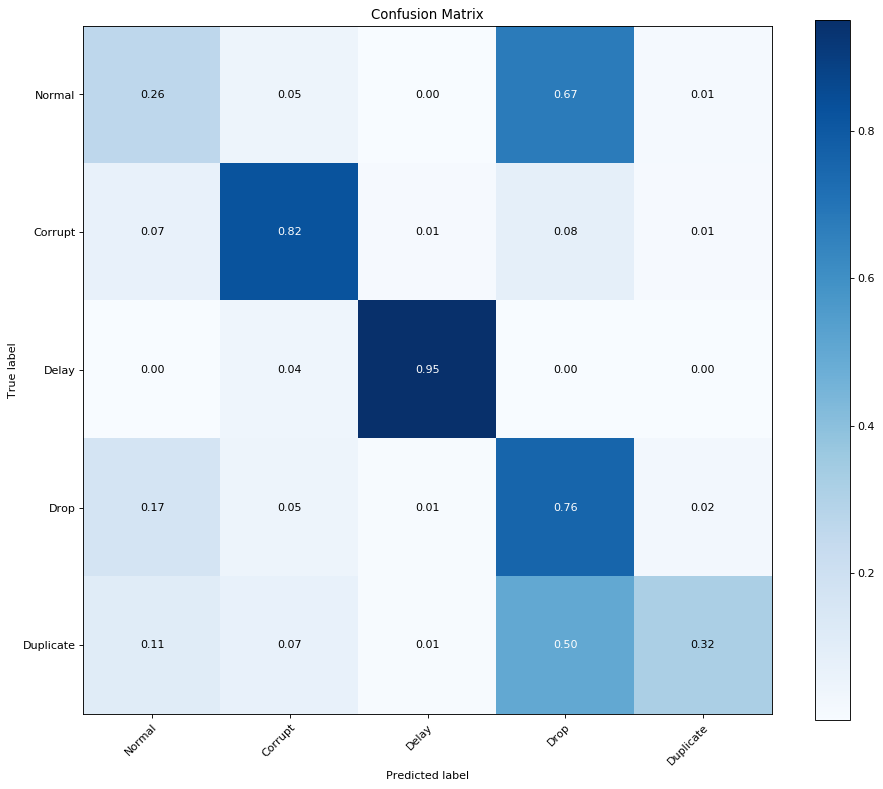

Total Error Count :  4565
Normal Class Error Rate :  13.470828688219994 %
Total Error Rate :  28.2732565341261 %
Total Errors 4565
False Positives  20.77294685990338 %
False Negatives  7.500309674222717 %


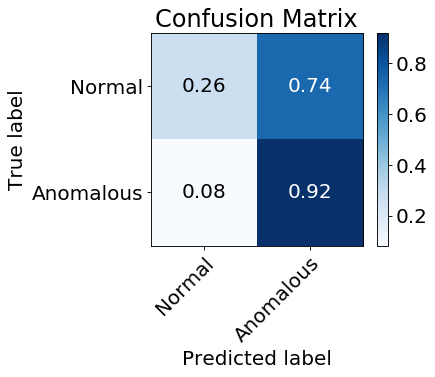

In [86]:
clf = svm.SVC(kernel='linear', gamma ='auto', max_iter=1000000000, class_weight='balanced')
clf.fit(train_data, train_labels)
predicted_labels = clf.predict(test_data)

from sklearn.metrics import confusion_matrix 

class_names = ["Normal", "Corrupt", "Delay", "Drop", "Duplicate"]

plot_confusion_matrix(test_labels, predicted_labels, normalize=True,classes=class_names, title='Confusion Matrix')
plt.show()

error_cnt = 0
total_error_cnt = 0
same_class_error = 0
for i in range(len(predicted_labels)):
    if predicted_labels[i] != test_labels[i]:
        total_error_cnt += 1
        # if its normal data
        if predicted_labels[i] == 1 or test_labels[i] == 1:
            error_cnt += 1


print ("Total Error Count : ", total_error_cnt)
print ("Normal Class Error Rate : ", float(error_cnt)/float(len(predicted_labels)) * 100, "%")
print ("Total Error Rate : ", float(total_error_cnt)/float(len(predicted_labels)) * 100, "%")


false_pos = 0
false_neg = 0
error_cnt = 0
for i in range(len(predicted_labels)):
    # if there's an error
    if predicted_labels[i] != test_labels[i]:
        error_cnt += 1
        # if we failed to detect anomaly
        if predicted_labels[i] == 1:
            false_neg += 1
        # detected anomaly, but it normal
        else:
            false_pos += 1
print ("Total Errors", error_cnt)
print ("False Positives ", false_pos/ float(len(predicted_labels)) * 100, "%")
print ("False Negatives ", false_neg/ float(len(predicted_labels)) * 100, "%")


shortened_predicted = []
shortened_test_label = []
for i in range(len(predicted_labels)):
    if predicted_labels[i] == 1:
        shortened_predicted.append(1)
    else:
        shortened_predicted.append(2)
    if test_labels[i] == 1:
        shortened_test_label.append(1)
    else:
        shortened_test_label.append(2)

short_class_names = ["Normal", "Anomalous"]        
        
    
    
plot_confusion_matrix(shortened_test_label, shortened_predicted, normalize=True,classes=short_class_names, 
                      title='Confusion Matrix', font_size=18, fig_size=(6,5))
plt.show()

In [87]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(all_data, 
                                                                    anom_type_data_labels, test_size=0.45, random_state=3)

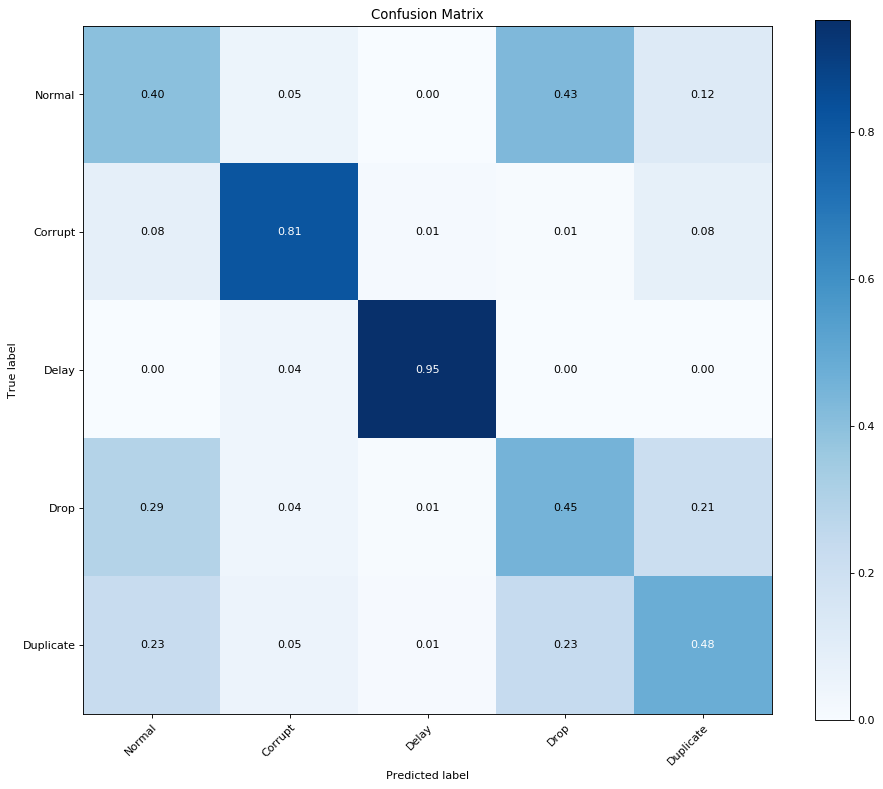

Total Error Count :  5171
Normal Class Error Rate :  17.47181964573269 %
Total Error Rate :  32.02650811346464 %
Total Errors 5171
False Positives  19.422767248854207 %
False Negatives  12.60374086461043 %


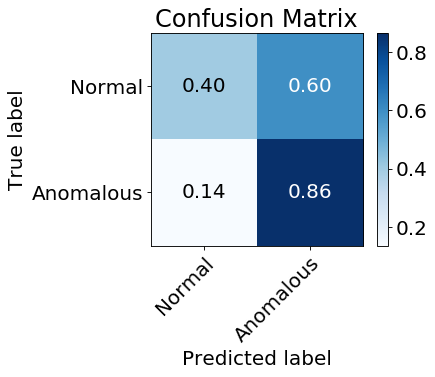

In [88]:
clf = svm.SVC(kernel='linear', gamma ='auto', max_iter=1000000000, class_weight='balanced')
clf.fit(train_data, train_labels)
predicted_labels = clf.predict(test_data)

from sklearn.metrics import confusion_matrix 

class_names = ["Normal", "Corrupt", "Delay", "Drop", "Duplicate"]

plot_confusion_matrix(test_labels, predicted_labels, normalize=True,classes=class_names, title='Confusion Matrix')
plt.show()

error_cnt = 0
total_error_cnt = 0
same_class_error = 0
for i in range(len(predicted_labels)):
    if predicted_labels[i] != test_labels[i]:
        total_error_cnt += 1
        # if its normal data
        if predicted_labels[i] == 1 or test_labels[i] == 1:
            error_cnt += 1


print ("Total Error Count : ", total_error_cnt)
print ("Normal Class Error Rate : ", float(error_cnt)/float(len(predicted_labels)) * 100, "%")
print ("Total Error Rate : ", float(total_error_cnt)/float(len(predicted_labels)) * 100, "%")


false_pos = 0
false_neg = 0
error_cnt = 0
for i in range(len(predicted_labels)):
    # if there's an error
    if predicted_labels[i] != test_labels[i]:
        error_cnt += 1
        # if we failed to detect anomaly
        if predicted_labels[i] == 1:
            false_neg += 1
        # detected anomaly, but it normal
        else:
            false_pos += 1
print ("Total Errors", error_cnt)
print ("False Positives ", false_pos/ float(len(predicted_labels)) * 100, "%")
print ("False Negatives ", false_neg/ float(len(predicted_labels)) * 100, "%")


shortened_predicted = []
shortened_test_label = []
for i in range(len(predicted_labels)):
    if predicted_labels[i] == 1:
        shortened_predicted.append(1)
    else:
        shortened_predicted.append(2)
    if test_labels[i] == 1:
        shortened_test_label.append(1)
    else:
        shortened_test_label.append(2)

short_class_names = ["Normal", "Anomalous"]        
        
    
    
plot_confusion_matrix(shortened_test_label, shortened_predicted, normalize=True,classes=short_class_names, 
                      title='Confusion Matrix', font_size=18, fig_size=(6,5))
plt.show()

In [89]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(all_data, 
                                                                    anom_type_data_labels, test_size=0.45, random_state=4)


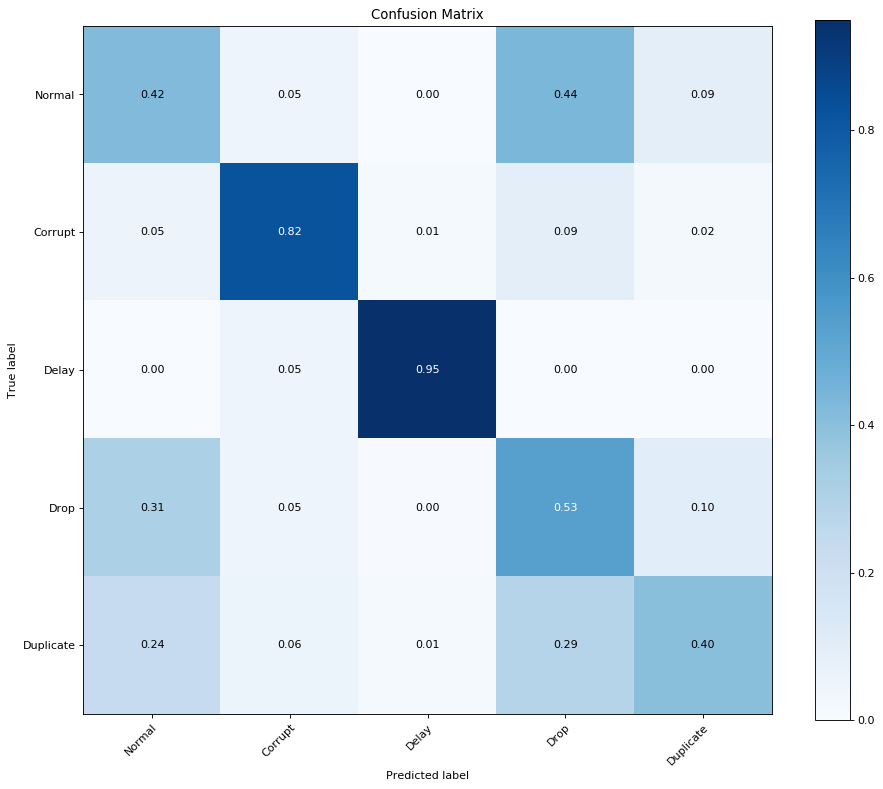

Total Error Count :  4973
Normal Class Error Rate :  17.032082249473554 %
Total Error Rate :  30.80019819150254 %
Total Errors 4973
False Positives  18.37606837606838 %
False Negatives  12.424129815434164 %


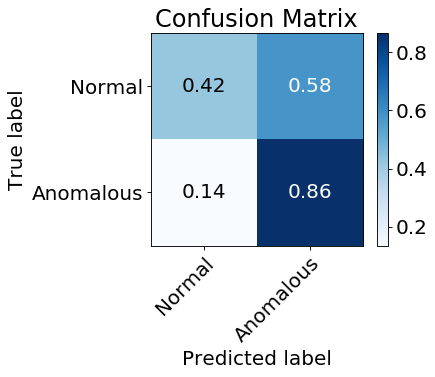

In [90]:
clf = svm.SVC(kernel='linear', gamma ='auto', max_iter=1000000000, class_weight='balanced')
clf.fit(train_data, train_labels)
predicted_labels = clf.predict(test_data)

from sklearn.metrics import confusion_matrix 

class_names = ["Normal", "Corrupt", "Delay", "Drop", "Duplicate"]

plot_confusion_matrix(test_labels, predicted_labels, normalize=True,classes=class_names, title='Confusion Matrix')
plt.show()

error_cnt = 0
total_error_cnt = 0
same_class_error = 0
for i in range(len(predicted_labels)):
    if predicted_labels[i] != test_labels[i]:
        total_error_cnt += 1
        # if its normal data
        if predicted_labels[i] == 1 or test_labels[i] == 1:
            error_cnt += 1


print ("Total Error Count : ", total_error_cnt)
print ("Normal Class Error Rate : ", float(error_cnt)/float(len(predicted_labels)) * 100, "%")
print ("Total Error Rate : ", float(total_error_cnt)/float(len(predicted_labels)) * 100, "%")


false_pos = 0
false_neg = 0
error_cnt = 0
for i in range(len(predicted_labels)):
    # if there's an error
    if predicted_labels[i] != test_labels[i]:
        error_cnt += 1
        # if we failed to detect anomaly
        if predicted_labels[i] == 1:
            false_neg += 1
        # detected anomaly, but it normal
        else:
            false_pos += 1
print ("Total Errors", error_cnt)
print ("False Positives ", false_pos/ float(len(predicted_labels)) * 100, "%")
print ("False Negatives ", false_neg/ float(len(predicted_labels)) * 100, "%")


shortened_predicted = []
shortened_test_label = []
for i in range(len(predicted_labels)):
    if predicted_labels[i] == 1:
        shortened_predicted.append(1)
    else:
        shortened_predicted.append(2)
    if test_labels[i] == 1:
        shortened_test_label.append(1)
    else:
        shortened_test_label.append(2)

short_class_names = ["Normal", "Anomalous"]        
        
    
    
plot_confusion_matrix(shortened_test_label, shortened_predicted, normalize=True,classes=short_class_names, 
                      title='Confusion Matrix', font_size=18, fig_size=(6,5))
plt.show()

In [91]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(all_data, 
                                                                    anom_type_data_labels, test_size=0.45, random_state=5)


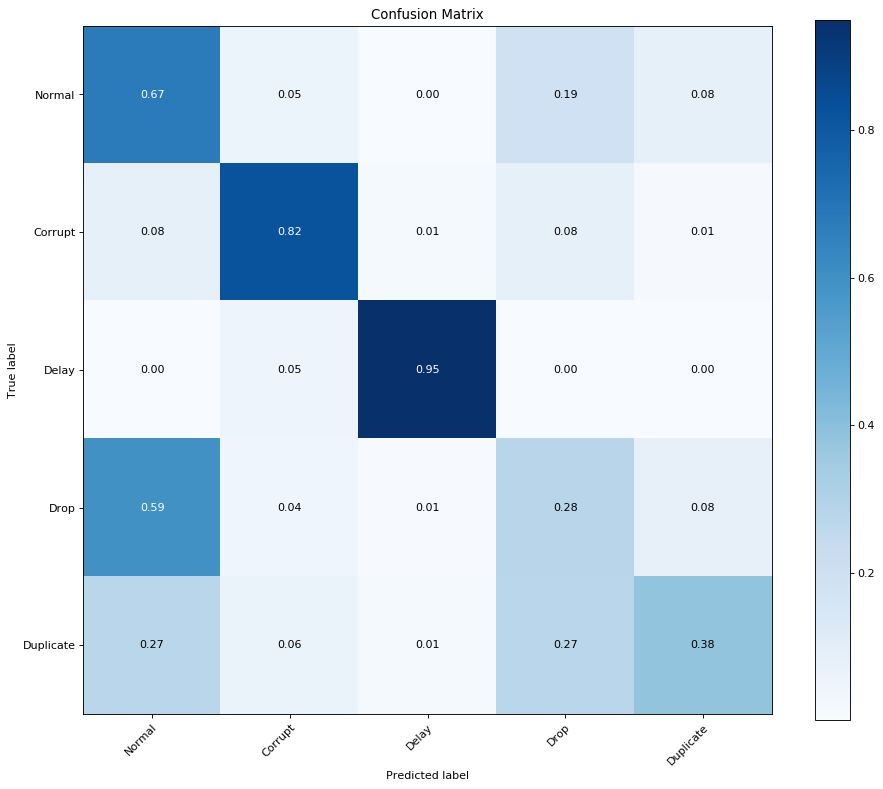

Total Error Count :  5769
Normal Class Error Rate :  23.349436392914654 %
Total Error Rate :  35.73021181716834 %
Total Errors 5769
False Positives  14.969651926173666 %
False Negatives  20.760559890994674 %


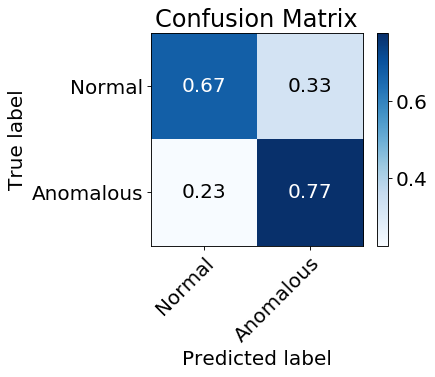

In [92]:
clf = svm.SVC(kernel='linear', gamma ='auto', max_iter=1000000000, class_weight='balanced')
clf.fit(train_data, train_labels)
predicted_labels = clf.predict(test_data)

from sklearn.metrics import confusion_matrix 

class_names = ["Normal", "Corrupt", "Delay", "Drop", "Duplicate"]

plot_confusion_matrix(test_labels, predicted_labels, normalize=True,classes=class_names, title='Confusion Matrix')
plt.show()

error_cnt = 0
total_error_cnt = 0
same_class_error = 0
for i in range(len(predicted_labels)):
    if predicted_labels[i] != test_labels[i]:
        total_error_cnt += 1
        # if its normal data
        if predicted_labels[i] == 1 or test_labels[i] == 1:
            error_cnt += 1


print ("Total Error Count : ", total_error_cnt)
print ("Normal Class Error Rate : ", float(error_cnt)/float(len(predicted_labels)) * 100, "%")
print ("Total Error Rate : ", float(total_error_cnt)/float(len(predicted_labels)) * 100, "%")


false_pos = 0
false_neg = 0
error_cnt = 0
for i in range(len(predicted_labels)):
    # if there's an error
    if predicted_labels[i] != test_labels[i]:
        error_cnt += 1
        # if we failed to detect anomaly
        if predicted_labels[i] == 1:
            false_neg += 1
        # detected anomaly, but it normal
        else:
            false_pos += 1
print ("Total Errors", error_cnt)
print ("False Positives ", false_pos/ float(len(predicted_labels)) * 100, "%")
print ("False Negatives ", false_neg/ float(len(predicted_labels)) * 100, "%")


shortened_predicted = []
shortened_test_label = []
for i in range(len(predicted_labels)):
    if predicted_labels[i] == 1:
        shortened_predicted.append(1)
    else:
        shortened_predicted.append(2)
    if test_labels[i] == 1:
        shortened_test_label.append(1)
    else:
        shortened_test_label.append(2)

short_class_names = ["Normal", "Anomalous"]        
        
    
    
plot_confusion_matrix(shortened_test_label, shortened_predicted, normalize=True,classes=short_class_names, 
                      title='Confusion Matrix', font_size=18, fig_size=(6,5))
plt.show()

In [93]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(all_data, 
                                                                    anom_type_data_labels, test_size=0.45, random_state=6 )


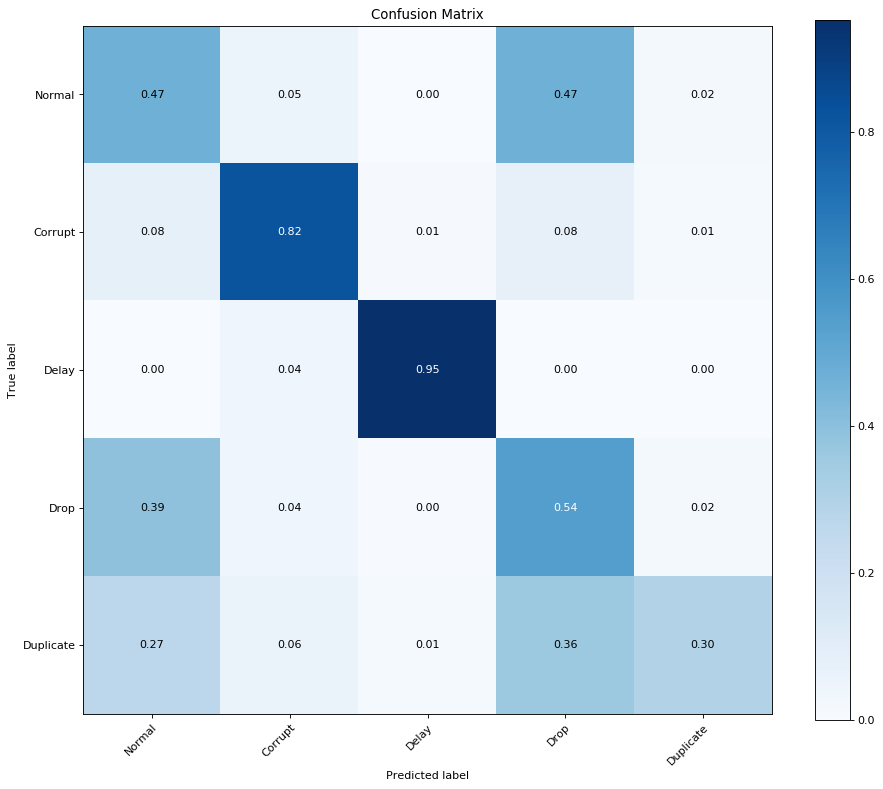

Total Error Count :  5172
Normal Class Error Rate :  19.8005698005698 %
Total Error Rate :  32.03270159791899 %
Total Errors 5172
False Positives  16.56137743094265 %
False Negatives  15.471324166976341 %


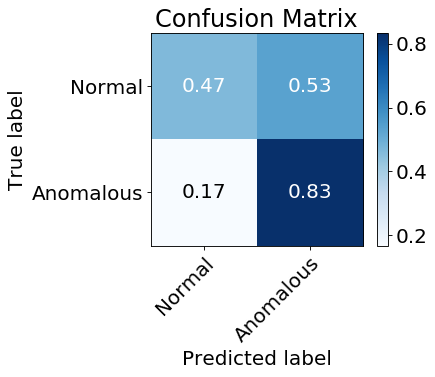

In [94]:
clf = svm.SVC(kernel='linear', gamma ='auto', max_iter=1000000000, class_weight='balanced')
clf.fit(train_data, train_labels)
predicted_labels = clf.predict(test_data)

from sklearn.metrics import confusion_matrix 

class_names = ["Normal", "Corrupt", "Delay", "Drop", "Duplicate"]

plot_confusion_matrix(test_labels, predicted_labels, normalize=True,classes=class_names, title='Confusion Matrix')
plt.show()

error_cnt = 0
total_error_cnt = 0
same_class_error = 0
for i in range(len(predicted_labels)):
    if predicted_labels[i] != test_labels[i]:
        total_error_cnt += 1
        # if its normal data
        if predicted_labels[i] == 1 or test_labels[i] == 1:
            error_cnt += 1


print ("Total Error Count : ", total_error_cnt)
print ("Normal Class Error Rate : ", float(error_cnt)/float(len(predicted_labels)) * 100, "%")
print ("Total Error Rate : ", float(total_error_cnt)/float(len(predicted_labels)) * 100, "%")


false_pos = 0
false_neg = 0
error_cnt = 0
for i in range(len(predicted_labels)):
    # if there's an error
    if predicted_labels[i] != test_labels[i]:
        error_cnt += 1
        # if we failed to detect anomaly
        if predicted_labels[i] == 1:
            false_neg += 1
        # detected anomaly, but it normal
        else:
            false_pos += 1
print ("Total Errors", error_cnt)
print ("False Positives ", false_pos/ float(len(predicted_labels)) * 100, "%")
print ("False Negatives ", false_neg/ float(len(predicted_labels)) * 100, "%")


shortened_predicted = []
shortened_test_label = []
for i in range(len(predicted_labels)):
    if predicted_labels[i] == 1:
        shortened_predicted.append(1)
    else:
        shortened_predicted.append(2)
    if test_labels[i] == 1:
        shortened_test_label.append(1)
    else:
        shortened_test_label.append(2)

short_class_names = ["Normal", "Anomalous"]        
        
    
    
plot_confusion_matrix(shortened_test_label, shortened_predicted, normalize=True,classes=short_class_names, 
                      title='Confusion Matrix', font_size=18, fig_size=(6,5))
plt.show()